# Langevin Dynamics of a free Particle


## Theory


#### What is the Langevin equation? What is the dissipation force and what is friction or damping? What is the fluctuation force... how does the fluctuation force depend on temperature and friction?

The langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p + \sqrt{2\xi k_BTm}\eta (t)$$

Where $V(q)$ is the potential enerqy function at postion $q$, $\Delta_q$ denotes the gradient with respect to the position coordinate, $\xi$ is the collision or friction rate, $T$ is the temperature, and $k_B$ is Boltzmann constant. $\eta$ is a Gaussian white noise with unit variance centered at zero.

The dissipation force is given by the therm $\xi p$ and it depends on the friction. 

The fluctuation force given by $\sqrt{2\xi k_BTm}\eta (t)$ it depends on the temperature. This force represents the impact of the molecules of the solvent on the particle.

#### How does the fluctuation force effectively enter into the equations of motion to be integrated? Is the dimensionality of the term correct?

#### What is a Brownian particle?

Brownian motion is the random motion of a small particle immersed in a fluid. A particle that follows this kind of motion is a brownian particle.

#### What happens to a free particle at zero temperature and zero friction if it initially has non-zero velocity?

At $T=0$ and $\xi=0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q)$$

Which is the standard form of Newton's second law. The differential equation is no longer stochastic.

#### What happens to a free particle at zero temperature and non-zero friction, if it initially has non-zero velocity?

At $T=0$ and $\xi\ne0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p$$

The viscous force will evantually grow bigger and stop the particle.

#### What happens to a free particle at nonzero temperature and zero friction, if it initially has a non-zero velocity?

At $T\ne0$ and $\xi=0$, the langevin equation is:

$$ \dot{p} = -\Delta_qV(q) + \sqrt{2\xi k_BTm}\eta (t)$$

#### What happens to a free particle at nonzero temperature and nonzero friction, if it initially has non-zero velocity?

At $T\ne0$ and $\xi\ne0$ the langevin equation is:

$$ \dot{p} = -\Delta_qV(q) - \xi p + \sqrt{2\xi k_BTm}\eta (t)$$

Which is the standard langevin equation. The trajectory of the particle will be stochastic.

#### What is the relationship between the average kinetic energy of a free particle and the temperature, and the kinetic energy given only by the X component of the velocity? Can you corroborate this relationship with a computational experiment? Do you think that this relationship could be used to calculate the temperature of the system by observing the average of the squared velocities of the particles of a system? Can you calculate analytically with statistical mechanics what is the expected kinetic energy of a free particle in a three-dimensional space at temperature T?

$$\langle\frac{1}{2}mv^2 \rangle = \frac{1}{2}k_BT$$

#### What is the diffusion of a particle, what is its relation with the mean square dispersion of a particle, and with the temperature? Could you perform the appropriate computational experiments to corroborate the relation between the temperature of the system and the mean square distance that a particle has advanced from its initial position in a time t?

Diffusion is defined as the movement of individual molecules of a substance through a semipermeable barrier from an area of higher concentration to an area of lower concentration. The diffusion equation is:

$$ \frac{\partial f}{\partial t} = D\frac{\partial^2 f}{\partial x^2}$$

Where D is the diffussion coefficient.

The diffussion coefficient is related to the mean square displacement of the particle and the temperature by the following relationship:

$$\lambda_x = \sqrt{\langle x^2 \rangle - \langle x^2_0 \rangle} = \sqrt{2Dt}$$

#### What is the fluctuation-dissipation theorem?

The fluctuation-dissipation theorem makes the connection between the spontaneous fluctuations in the system in equilibrium, as described by the non-retarded correlation function S(ω), and the response of the system to external perturbations, as determined by the susceptibility.

#### In the computational experiments you carried out, how did you choose the integration step? Is there any constraint to choose a small or large integration step?



In [1]:
%matplotlib inline

import openmm
import openmm.app as app
import openmm.unit as unit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Simulation Set Up

In this firs part of the notebook we setup the parameters of the simulation of an argon atom.

In [2]:
def create_topology():
    """ Create a topology with an argon atom.
        
        Returns
        -------
        openmm.app.Topology
    """
    topology = app.Topology()
    chain = topology.addChain()
    residue = topology.addResidue("Ar",chain)
    argon = app.Element.getBySymbol("Ar")
    topology.addAtom("Ar", argon, residue)
    return topology

In [3]:
def create_system():
    """ Create the system with an argon atom.
        
        Returns
        -------
        openmm.System
    """
    system = openmm.System()
    system.addParticle(39.948 * unit.amu) # Ar mass
    return system

In [4]:
def create_simulation_obj(topo, syst, step, platform_name="CPU"):
    """ Returns a simulation object.
    
        Returns
        -------
        openmm.app.Simulation
    """
    temperature = 300*unit.kelvin
    friction_coeff = 1.0/unit.picosecond
    
    integrator = openmm.LangevinIntegrator(
        temperature, friction_coeff, step
    )
    
    # Initial position and velocities
    pos = np.zeros((1, 3), np.float32) * unit.angstroms
    vel = np.zeros((1, 3), np.float32) * unit.angstroms/unit.picoseconds
    
    platform = openmm.Platform.getPlatformByName(platform_name)
    
    simulation = app.Simulation(topology, system, integrator, platform)
    
    simulation.context.setPositions(pos)
    simulation.context.setVelocities(vel)
    
    return simulation

In [5]:
# Integration step
step_size = 0.1*unit.picosecond

topology = create_topology()
system = create_system()
simulation = create_simulation_obj(topology, system, step_size)

## Running the simulation

In [6]:
def run_sim(sim, step, sim_time, save_time):
    """ Run the simluation while saving the positions, times and velocities
        to numpy arrays
        
        Returns
        -------
        tuple[np.ndarray]
            An array for time, position and velocity.
    """
    n_steps_per_period = int(save_time/step)
    n_periods = int(sim_time/save_time)
    
    print()

    time = np.zeros([n_periods], np.float32) * unit.picoseconds
    position = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms
    velocity = np.zeros([n_periods, 1, 3], np.float32) * unit.angstroms/unit.picosecond
    
    for ii in tqdm(range(n_periods)):
        sim.step(n_steps_per_period)
        state = sim.context.getState(getPositions=True, getVelocities=True)
        
        time[ii] = state.getTime()
        position[ii] = state.getPositions()
        velocity[ii] = state.getVelocities()
    
    return time, position, velocity

In [7]:
times, pos, vel = run_sim(
    simulation,
    step_size,
    sim_time=2.0*unit.nanosecond,
    save_time=1.0*unit.picoseconds
)

100%|█████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1293.56it/s]


## Analyzing the simulation

In [8]:
def plot_coordinates(time, positions):
    """ Plot the x, y and z coordinate against time. Each coordinate in
        a different plot.
    """    

    plt.rcParams['figure.figsize'] = 18, 4

    for ii, axis_label in zip(range(3),['X','Y','Z']):
        plt.plot(times, positions[:,0,ii])
        plt.ylabel('{} ({})'.format(axis_label, positions.unit))
        plt.xlabel('time ({})'.format(times.unit))
        plt.show()


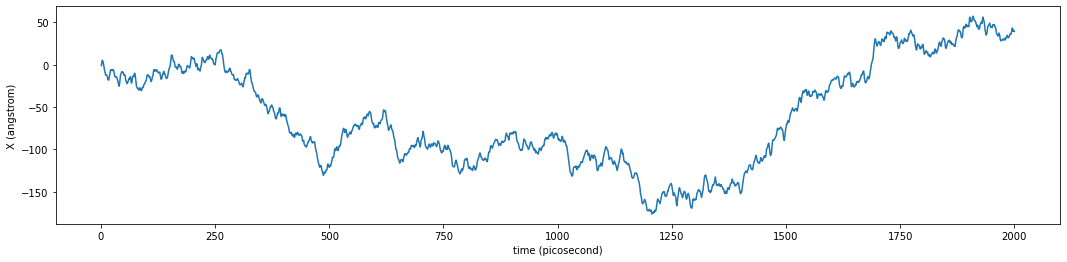

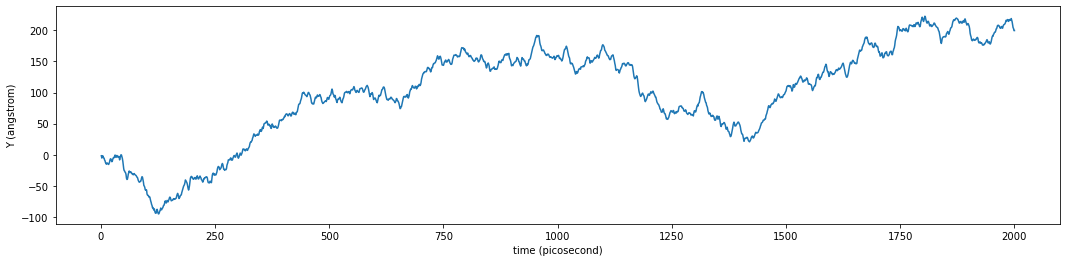

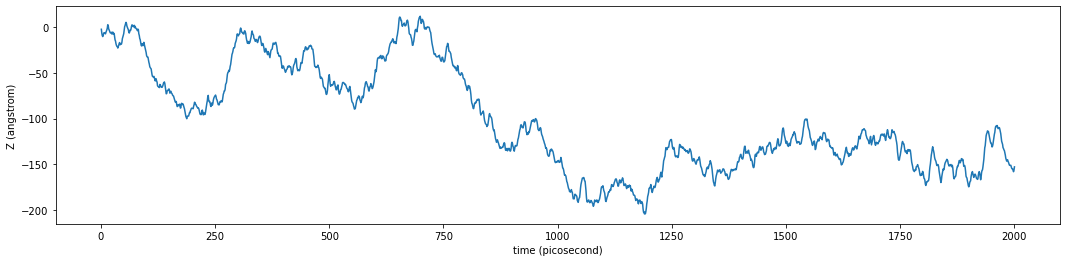

In [9]:
plot_coordinates(times, pos)

In [10]:
def plot_2d(positions):
    plt.rcParams['figure.figsize'] = 5, 5

    plt.plot(positions[:,0,0], positions[:,0,1])
    plt.xlabel('X ({})'.format(positions.unit))
    plt.ylabel('Y ({})'.format(positions.unit))
    plt.show()

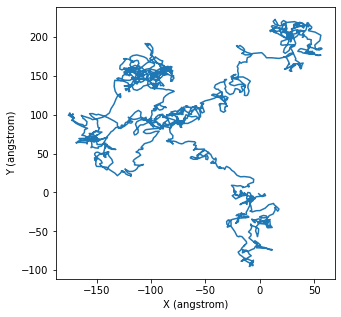

In [11]:
plot_2d(pos)